# Predicting Credit Risk. A comparison between Logistic Regression, Decision Tree and ANN

# Logistic Regression

In [4]:
#Loading the libraries

import pandas as pd # To work with the dataset
import numpy as np #Math library
import seaborn as sns #Graph library that use matplot in background
import matplotlib.pyplot as plt #to plot some parameters in seaborn
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
import os # accessing directory structure


#Importing the data
df_credit = pd.read_csv("german_credit_target.csv",index_col=0)

In [5]:
# Have a look to the data 

print(df_credit.info())
print()

#Looking unique values
print(df_credit.nunique())
print()

#Looking the data
print(df_credit.head())
print()

df_credit.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB
None

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64

   Age     Sex  Job Housing Sav

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [6]:
df_credit.isna()
# It can be explicitely set to include them, use "help(D.mean)" to get more help
#print(df_credit.head().mean(skipna=False))

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,False,False,False,False,True,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,True,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
995,False,False,False,False,False,True,False,False,False,False
996,False,False,False,False,False,False,False,False,False,False
997,False,False,False,False,False,True,False,False,False,False
998,False,False,False,False,False,False,False,False,False,False


In [7]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

/var/folders/n3/lsk94q496hs_2rtbpj5bk6x80000gn/T/ipykernel_5487/964395601.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nGraphRow, nGraphPerRow, i + 1)
/var/folders/n3/lsk94q496hs_2rtbpj5bk6x80000gn/T/ipykernel_5487/964395601.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nGraphRow, nGraphPerRow, i + 1)
/var/folders/n3/lsk94q496hs_2rtbpj5bk6x80000gn/T/ipykernel_5487/964395601.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nGraphRow, nGraphPerRow, i + 1)
/var/folders/n3/lsk94q496hs_2rtbpj5bk6x80000gn/T/ipykernel_5487/964395601.py:10: MatplotlibDeprecationWarning: Passing non-integers as t

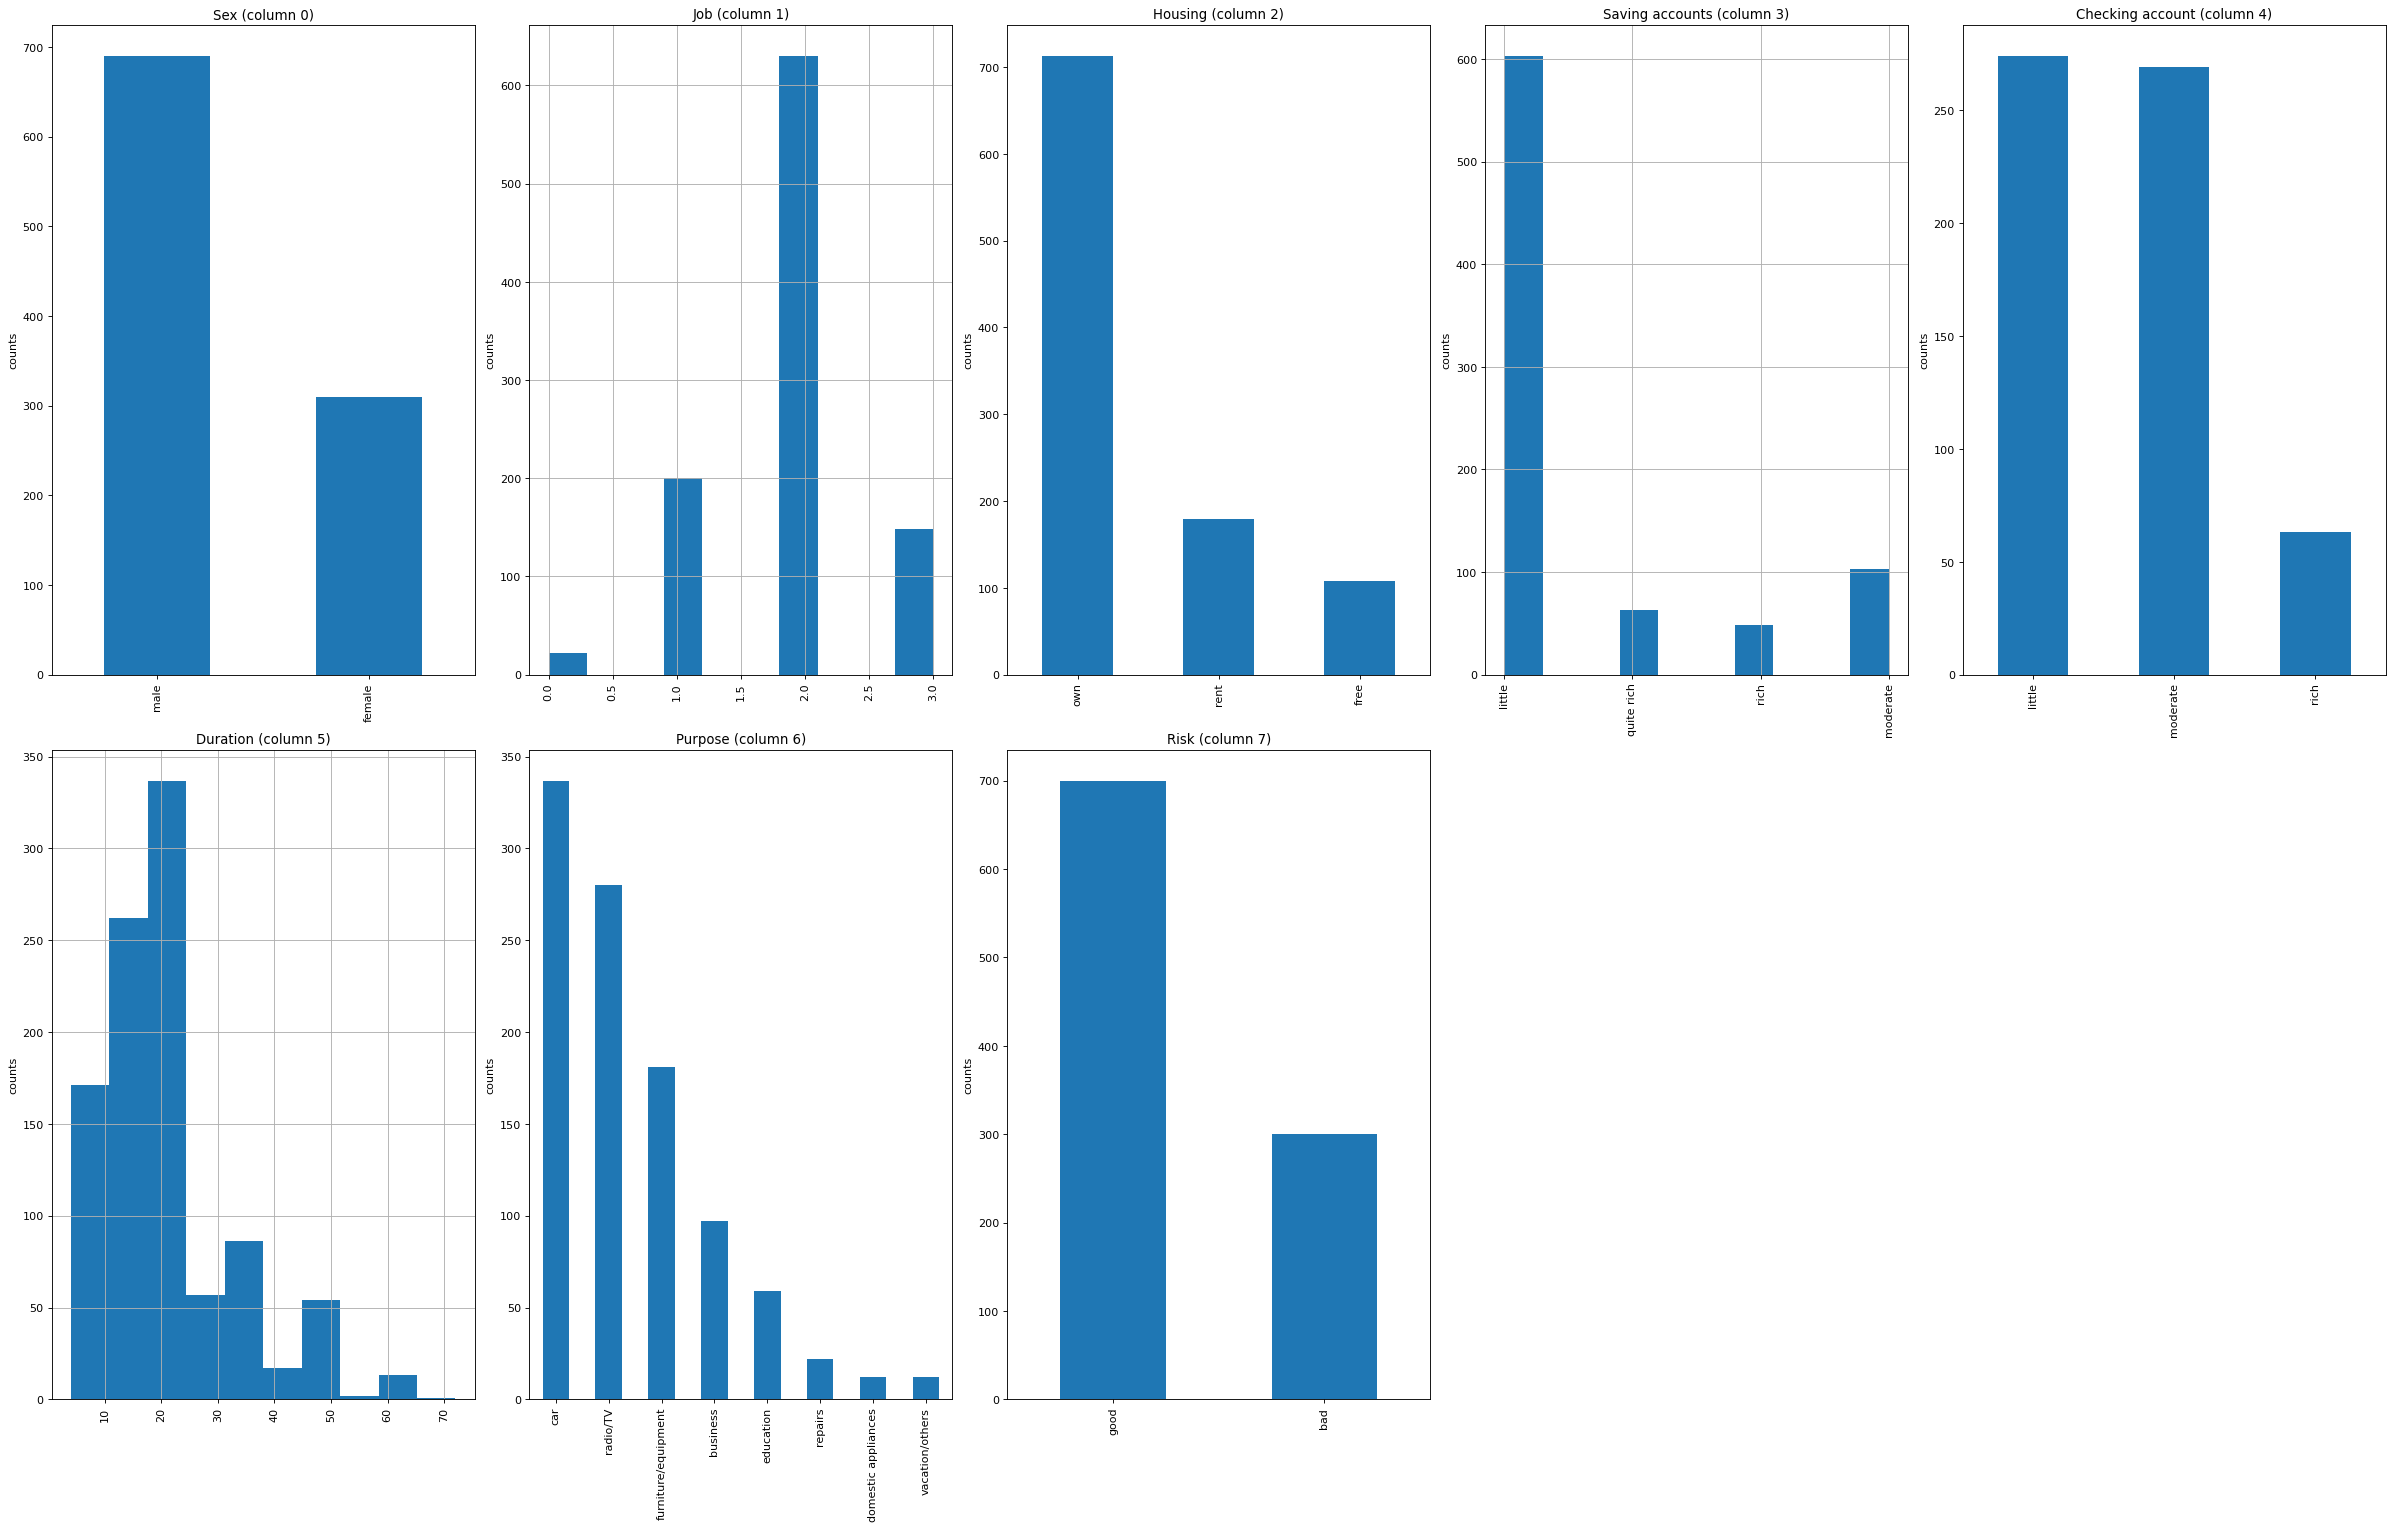

In [8]:
plotPerColumnDistribution(df_credit, 10, 5)

In [9]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    df_credit.dataframeName = 'german_credit_target.csv'
    filename = df_credit.dataframeName
    df = df_credit.dropna('columns') # drop columns with NaN
    df = df_credit[[col for col in df if df_credit[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df_credit.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df_credit.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

/var/folders/n3/lsk94q496hs_2rtbpj5bk6x80000gn/T/ipykernel_5487/2955551710.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  df = df_credit.dropna('columns') # drop columns with NaN


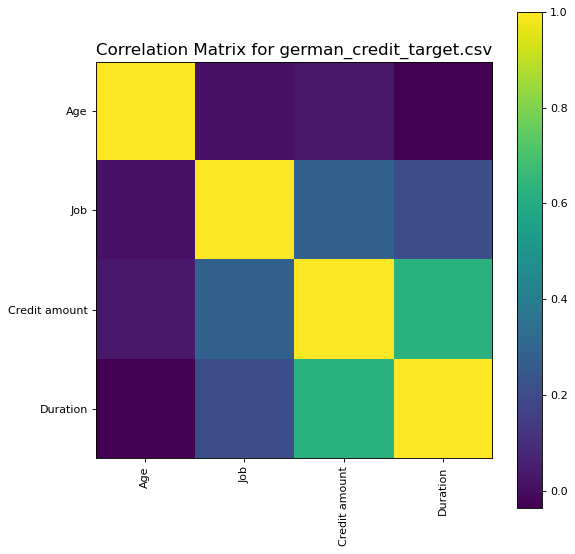

In [10]:
plotCorrelationMatrix(df_credit, 8)

In [11]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df_credit.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df_credit.dropna('columns')
    df = df_credit[[col for col in df if df_credit[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df_credit[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

/var/folders/n3/lsk94q496hs_2rtbpj5bk6x80000gn/T/ipykernel_5487/175421121.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  df = df_credit.dropna('columns')


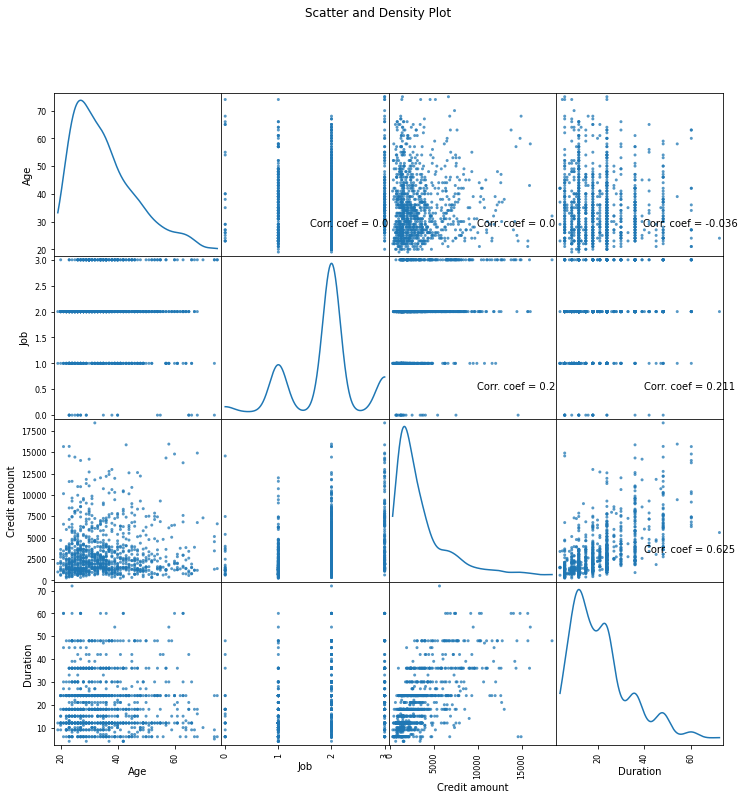

In [12]:
plotScatterMatrix(df_credit, 12, 10)

In [14]:
# Building the model for Logistic regression
from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score
from sklearn.linear_model import LogisticRegression
from collections import Counter
df = df_credit.select_dtypes(include =[np.number]) # keep only numerical columns
X = df
y = df_credit["Risk"]

#dealing with Imbalanced Classes data (Using Synthetic Minority Oversampling Technique - SMOTE)
#smote = SMOTE()

# fit predictor and target variable
X_smote, y_smote = smote.fit_resample(X, y)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_smote))


#Spliting the dataset into train set and test set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25,random_state=42)



logre = LogisticRegression().fit(X,y)
y_pred = logre.predict(X_train)

logre.score(X_test, y_test)
print()
#confusion_matrix(y_test, y_pred)

RsquaredCV=cross_val_score(logre, X, y, cv=5).mean()
RsquaredTR=logre.score(X,y)
print("Logistic Regression score:", logre.score(X_test, y_test))
print("CV score..........", RsquaredCV)
print("Training score....", RsquaredTR)


Original dataset shape Counter({'good': 700, 'bad': 300})

Logistic Regression score: 0.74
CV score.......... 0.709
Training score.... 0.712


## Artificial Neural Networks (ANN) MLPRegressor & ExtraTreesRegressor

In [15]:
#Import needed libraries
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


In [16]:
#Load the dataset for ANN model
df_ANN=pd.read_csv('german_credit_target.csv',index_col=0)

In [17]:
#set the good=1 and bad =0 same Sex and Housing columns
#Here we will add more columns because ANN models need more data than "normal" ML models
df_ANN['Sex']=(df_ANN['Sex']=='male').astype(int)
df_ANN['Housing']=(df_ANN['Housing']=='own').astype(int)
df_ANN['Risk']=(df_ANN['Risk']=='good').astype(int)
#Drop columns: 'Saving accounts', 'Checking account' and 'Purpose'
df_ANN=df_ANN.drop(columns=['Saving accounts', 'Checking account','Purpose'])
df_ANN

,Age,Sex,Job,Housing,Credit amount,Duration,Risk
0,67,1,2,1,1169,6,1
1,22,0,2,1,5951,48,0
2,49,1,1,1,2096,12,1
3,45,1,2,0,7882,42,1
4,53,1,2,0,4870,24,0
...,...,...,...,...,...,...,...
995,31,0,1,1,1736,12,1
996,40,1,3,1,3857,30,1
997,38,1,2,1,804,12,1
998,23,1,2,0,1845,45,0


In [18]:
#Set the features to the X_ANN
X_ANN= df_ANN.iloc[: , :6]
#Set the target value to the target_ANN
target_ANN =df_ANN.iloc[: ,6:7]
#MLPRegressor does the training -> no need fo training and testing set.
#(Numeber of layers,number of neurons in layer),
%time predictorMLP=MLPRegressor((3,80),random_state=2, max_iter=1000).fit(X_ANN, target_ANN.values.ravel())

CPU times: user 541 ms, sys: 182 ms, total: 722 ms
Wall time: 160 ms


In [19]:
%time y_predMLP=predictorMLP.predict(X_ANN)
accuracyMLP=r2_score(target_ANN, y_predMLP)
#accuracyScore=MLPR.score(X, y) same as r2-score

accuracyMLP_cv=cross_val_score(predictorMLP, X_ANN, target_ANN.values.ravel(), cv=5).mean()
print("Prediction accuracy in training set is", accuracyMLP)
print("Prediction accuracy in cv is          ", accuracyMLP_cv)

CPU times: user 7.52 ms, sys: 3.06 ms, total: 10.6 ms
Wall time: 13.1 ms
Prediction accuracy in training set is 0.043314152491549684
Prediction accuracy in cv is           0.026526035636911027


In [20]:
#Let's try ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [34]:
#Uses the same target group.
%time predictorETR=ExtraTreesRegressor(n_estimators=1000,max_depth=1, random_state=1).fit(X_ANN, target_ANN.values.ravel())
%time y_hatETR=predictorETR.predict(X_ANN)
ExtraAccuracy=r2_score(target_ANN, y_hatETR)
ExtraCVScore=cross_val_score(predictorETR, X_ANN, target_ANN.values.ravel(), cv=5).mean()
print("Prediction accuracy in training set is", ExtraAccuracy)
print("Prediction accuracy in cv is          ", ExtraCVScore)

CPU times: user 394 ms, sys: 8.04 ms, total: 402 ms
Wall time: 401 ms
CPU times: user 44.3 ms, sys: 763 µs, total: 45.1 ms
Wall time: 45 ms
Prediction accuracy in training set is 0.037765073761232726
Prediction accuracy in cv is           0.015493488976662561


In [35]:
#Problem is clearly classification problem so we should use MLPClassifier and ExtraTreesClassifier insted

In [36]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

In [39]:
#Spliting the dataset into train set and test set
X_train, X_test, y_train, y_test = train_test_split(X_ANN,target_ANN.values.ravel(),test_size = 0.25,random_state=2)
clf = MLPClassifier(random_state=1, max_iter=120).fit(X_train, y_train)


clf.score(X_test, y_test)


0.48

In [48]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier(n_estimators=100, random_state=1)
etc.fit(X_train, y_train)
score = etc.score(X_test, y_test)
print("Score: ", score)
cv_scores = cross_val_score(etc, X_test, y_test, cv=5 )
print("CV average score: %.2f" % cv_scores.mean())



Score:  0.652
CV average score: 0.64


MLPRegressor model performed better than ExtraTreessRegressor yet the model is not good for this purposes. The data set is too small and simple. However this is classification problem so we should use Classifiers instead.
ExtraTreesClassifier provides more accurate results than MLPClassifier.


## Random Forest Classifier

In [1]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators= 1000)

# fit the predictor and target
rfc.fit(X, y)
feature_imp = pd.DataFrame({'Variable':X.columns,'importance':rfc.feature_importance_}).sort_values('importance', ascending=False)
print(feature_imp)
# predict
rfc_y_predict = rfc.predict(X_test)

# check performance
rfc_score = rfc.score(X_test, y_test)
rfc_RsquaredCV = cross_val_score(rfc, X, y, cv=5).mean()
rfc_RsquaredTR = rfc.score(X,y)

print("Random Forest Classifier score:", rfc_score)
print("CV score:", rfc_RsquaredCV)
print("Training score:", rfc_RsquaredTR)


NameError: name 'X' is not defined

Lets use Random Forest Classifier model for selecting the most relevant features (It is the model with the higher quality score)